In [ ]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, vaccination_dashboard
import requests

In [ ]:
release=None

In [12]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-12,2021-01-11,United Kingdom,K02000001,NaN,NaN,NaN,536947.0
1,2021-01-12,2021-01-10,United Kingdom,K02000001,26287.0,NaN,563.0,485874.0
2,2021-01-12,2021-01-09,United Kingdom,K02000001,33550.0,NaN,595.0,567302.0
3,2021-01-12,2021-01-08,United Kingdom,K02000001,44997.0,NaN,682.0,680215.0
4,2021-01-12,2021-01-07,United Kingdom,K02000001,50992.0,4240.0,799.0,619941.0
...,...,...,...,...,...,...,...,...
343,2021-01-12,2020-02-03,United Kingdom,K02000001,0.0,NaN,NaN,NaN
344,2021-01-12,2020-02-02,United Kingdom,K02000001,0.0,NaN,NaN,NaN
345,2021-01-12,2020-02-01,United Kingdom,K02000001,1.0,NaN,NaN,NaN
346,2021-01-12,2020-01-31,United Kingdom,K02000001,1.0,NaN,NaN,NaN


In [13]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-12.csv')

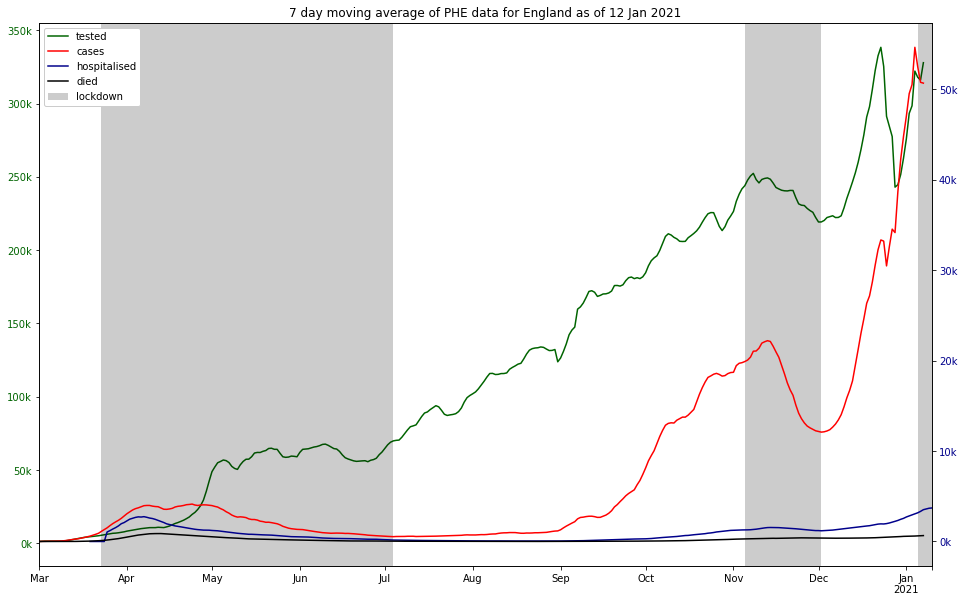

In [14]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [4]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-12.csv')

In [5]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-12.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,15288.0,84187.0,68899.0,1893667,0.807323,3.638390,95.554287
1,Scotland,S92000003,2857.0,175942.0,173085.0,5463300,0.052294,3.168140,96.779565
2,Wales,W92000004,97.0,91239.0,91142.0,3152879,0.003077,2.890755,97.106169
3,England,E92000001,393925.0,2080280.0,1686355.0,56286961,0.699851,2.995996,96.304153


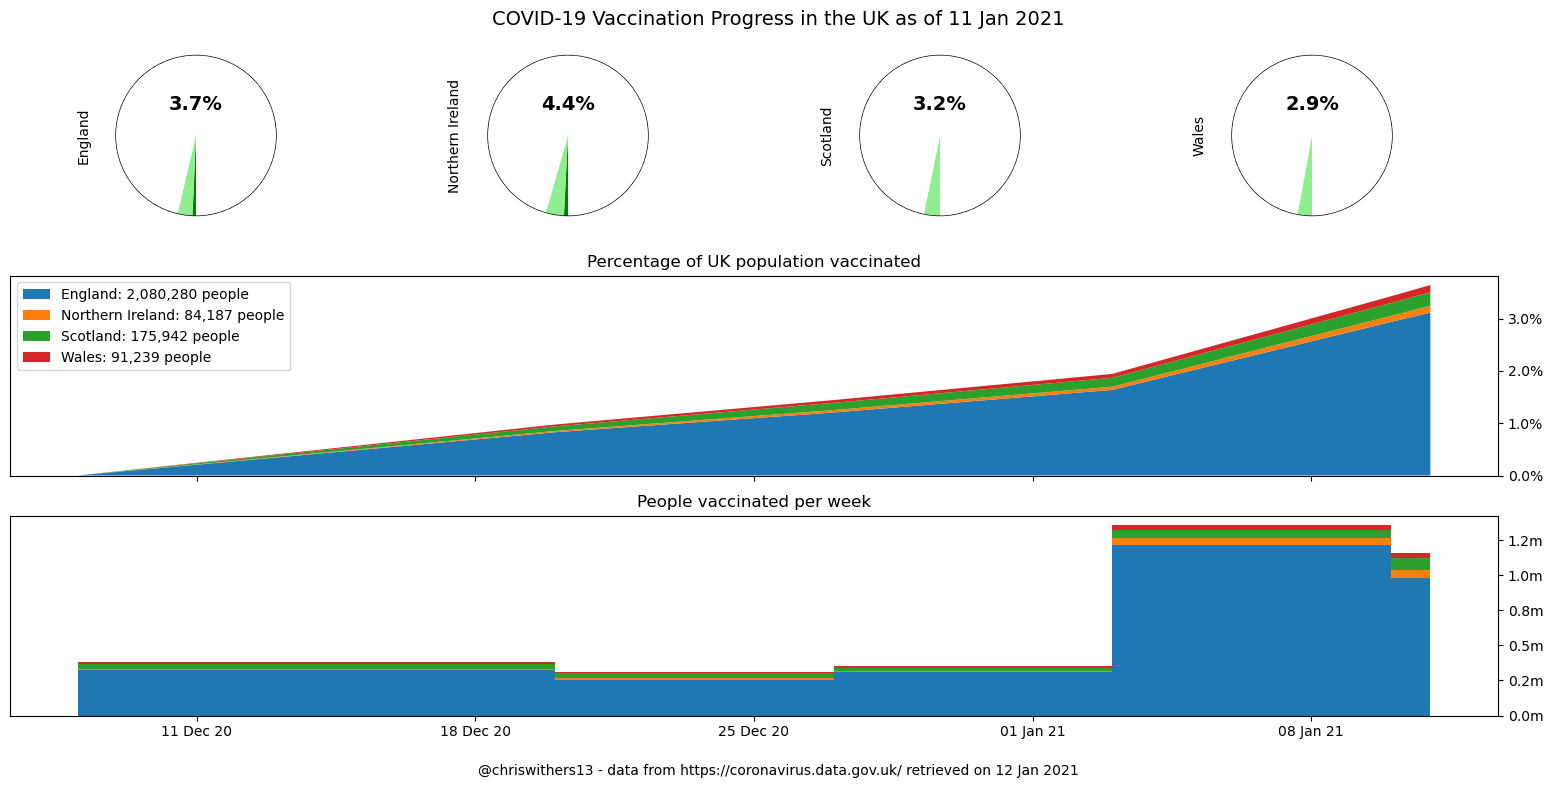

In [3]:
vaccination_dashboard()

In [18]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-12.csv')

In [19]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-12.csv')

In [20]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-12.csv')

In [21]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-12, release: 2021-01-12 16:50:14.444397+00:00, msoa: 2021-01-12 17:09:20+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-12.csv')